# Thyroid Cancer Recurrence Prediction Model

This notebook analyzes thyroid cancer patient data and builds a deep learning model to predict cancer recurrence.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight as class_weight 
from imblearn.over_sampling import SMOTE
import io
import pickle
import os

## 1. Load and Explore the Dataset

In [ ]:
data = pd.read_csv("dataset.csv")

print("Dataset Shape:", data.shape)
print("\nFirst 5 rows of the dataset:")
display(data.head())
print("\nData types:")
print(data.dtypes)
print("\nMissing values:")
print(data.isnull().sum())

Dataset Shape: (383, 17)

First 5 rows of the dataset:


,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No



Data types:
Age                      int64
Gender                  object
Smoking                 object
Hx Smoking              object
Hx Radiothreapy         object
Thyroid Function        object
Physical Examination    object
Adenopathy              object
Pathology               object
Focality                object
Risk                    object
T                       object
N                       object
M                       object
Stage                   object
Response                object
Recurred                object
dtype: object

Missing values:
Age                     0
Gender                  0
Smoking                 0
Hx Smoking              0
Hx Radiothreapy         0
Thyroid Function        0
Physical Examination    0
Adenopathy              0
Pathology               0
Focality                0
Risk                    0
T                       0
N                       0
M                       0
Stage                   0
Response                0
Recurred     

## 2. Data Preprocessing

In [ ]:
if data['Age'].dtype == 'object':
    data['Age'] = pd.to_numeric(data['Age'], errors='coerce')

data = data.fillna(data.mode().iloc[0])

print("\nTarget variable distribution:")
print(data['Recurred'].value_counts())
print(data['Recurred'].value_counts(normalize=True))


Target variable distribution:
Recurred
No     275
Yes    108
Name: count, dtype: int64
Recurred
No     0.718016
Yes    0.281984
Name: proportion, dtype: float64


## 3. Data Visualization

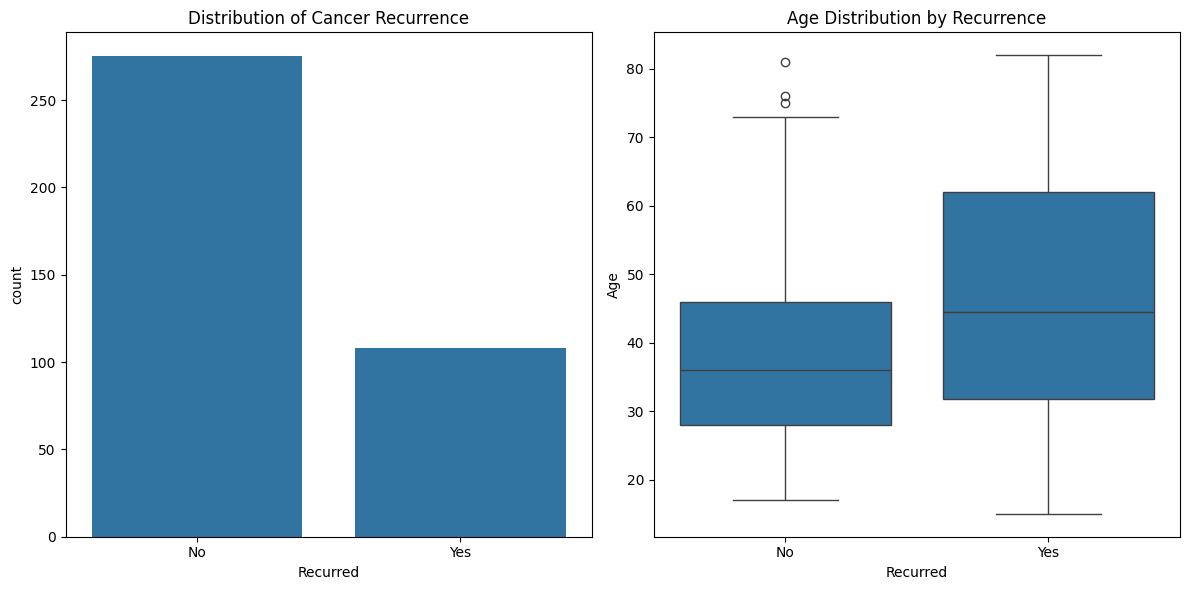

<Figure size 1000x600 with 0 Axes>

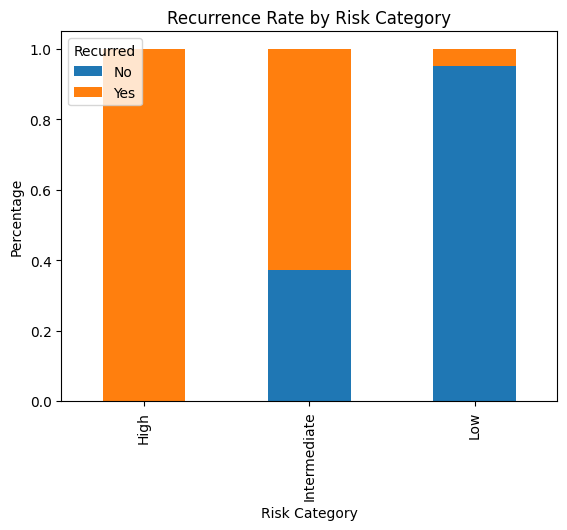

<Figure size 1000x600 with 0 Axes>

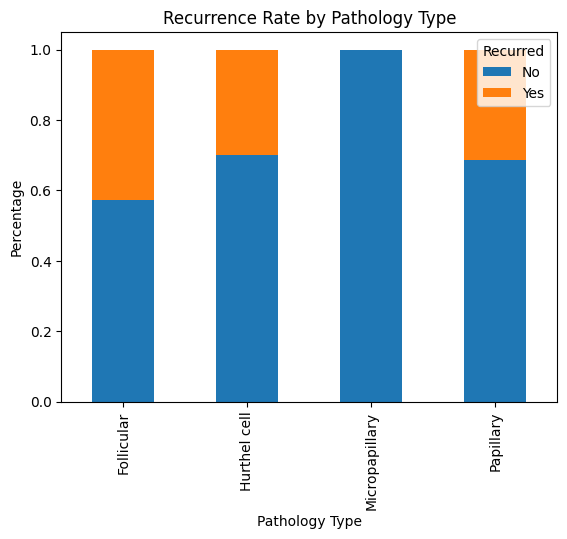

<Figure size 1200x600 with 0 Axes>

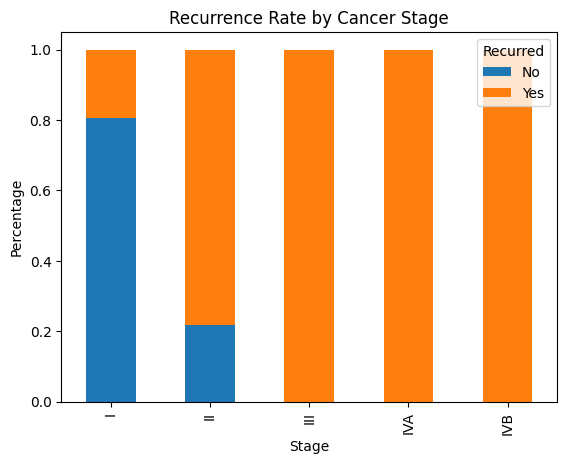

In [9]:
plt.figure(figsize=(12, 6))

# Distribution of target variable
plt.subplot(1, 2, 1)
sns.countplot(x=data['Recurred'])
plt.title('Distribution of Cancer Recurrence')

# Age distribution by recurrence
plt.subplot(1, 2, 2)
sns.boxplot(x='Recurred', y='Age', data=data)
plt.title('Age Distribution by Recurrence')

plt.tight_layout()
plt.show()

# Correlation between risk and recurrence
plt.figure(figsize=(10, 6))
risk_recurrence = pd.crosstab(data['Risk'], data['Recurred'])
risk_recurrence_pct = risk_recurrence.div(risk_recurrence.sum(1).astype(float), axis=0)
risk_recurrence_pct.plot(kind='bar', stacked=True)
plt.title('Recurrence Rate by Risk Category')
plt.xlabel('Risk Category')
plt.ylabel('Percentage')
plt.show()

# Pathology type and recurrence
plt.figure(figsize=(10, 6))
path_recurrence = pd.crosstab(data['Pathology'], data['Recurred'])
path_recurrence_pct = path_recurrence.div(path_recurrence.sum(1).astype(float), axis=0)
path_recurrence_pct.plot(kind='bar', stacked=True)
plt.title('Recurrence Rate by Pathology Type')
plt.xlabel('Pathology Type')
plt.ylabel('Percentage')
plt.show()

# Stage and recurrence
plt.figure(figsize=(12, 6))
stage_recurrence = pd.crosstab(data['Stage'], data['Recurred'])
stage_recurrence_pct = stage_recurrence.div(stage_recurrence.sum(1).astype(float), axis=0)
stage_recurrence_pct.plot(kind='bar', stacked=True)
plt.title('Recurrence Rate by Cancer Stage')
plt.xlabel('Stage')
plt.ylabel('Percentage')
plt.show()

## 4. Feature Engineering and Data Preparation

In [7]:
# Define target variable
X = data.drop('Recurred', axis=1)
y = data['Recurred'].map({'Yes': 1, 'No': 0})

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nCategorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

# Create preprocessing pipelines for both numerical and categorical data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocess the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\nProcessed training data shape: {X_train_processed.shape}")


Categorical columns: ['Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy', 'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response']
Numerical columns: ['Age']

Processed training data shape: (306, 55)


## 5. Handle Class Imbalance with SMOTE

Since we have an issue with the model predicting "NO" too frequently, we'll use SMOTE to oversample the minority class.

In [8]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print("Original class distribution:")
print(pd.Series(y_train).value_counts())

print("\nResampled class distribution:")
print(pd.Series(y_train_smote).value_counts())

Original class distribution:
Recurred
0    220
1     86
Name: count, dtype: int64

Resampled class distribution:
Recurred
1    220
0    220
Name: count, dtype: int64


## 6. Build and Train the Deep Learning Model

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights correctly
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))  
print("Class weights:", class_weight_dict)

# Build the deep learning model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_processed.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Class weights: {np.int64(0): np.float64(0.6954545454545454), np.int64(1): np.float64(1.7790697674418605)}


d:\Software\Anaconda\envs\workplace\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,537 (68.50 KB)

 Trainable params: 17,537 (68.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train_smote, y_train_smote,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6126 - loss: 0.6576 - val_accuracy: 0.0000e+00 - val_loss: 0.8545
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7439 - loss: 0.5378 - val_accuracy: 0.6250 - val_loss: 0.7256
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8305 - loss: 0.4227 - val_accuracy: 0.8523 - val_loss: 0.4100
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8957 - loss: 0.3056 - val_accuracy: 0.8636 - val_loss: 0.2872
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8983 - loss: 0.2330 - val_accuracy: 0.8409 - val_loss: 0.2994
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9115 - loss: 0.2280 - val_accuracy: 0.9091 - val_loss: 0.1855
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9079 - loss: 0.2172 - val_accuracy: 0.9318 - val_loss: 0.1675
Epoch 8/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9469 - loss: 0.1558 - val_accuracy

## 7. Evaluate the Model

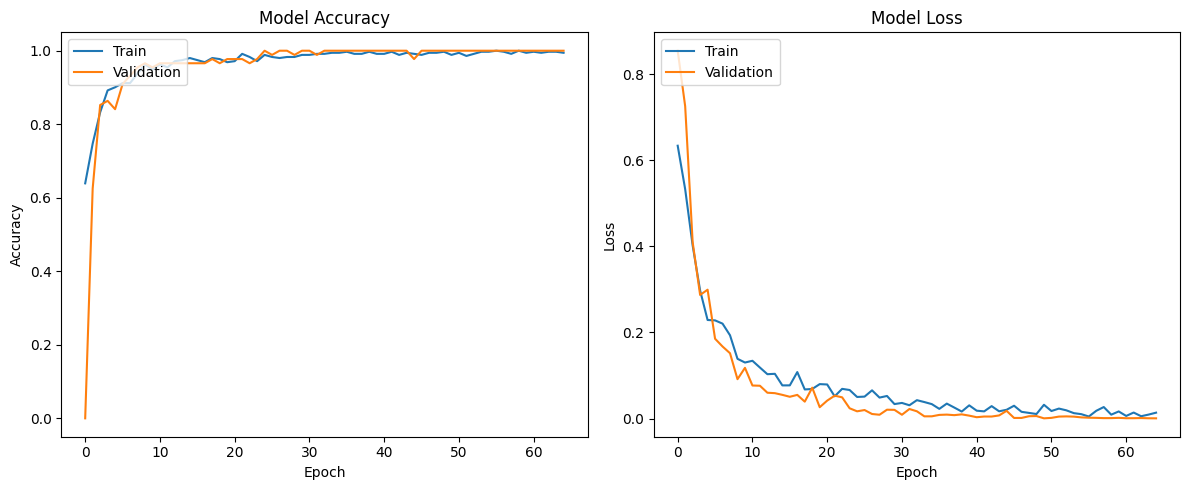

In [16]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
y_pred_prob = model.predict(X_test_processed)

thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_prob > threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f1)
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
print(f"\nBest threshold: {best_threshold:.2f} with F1 Score: {f1_scores[best_threshold_idx]:.4f}")

y_pred = (y_pred_prob > best_threshold).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
Threshold: 0.10, F1 Score: 0.9333
Threshold: 0.15, F1 Score: 0.9333
Threshold: 0.20, F1 Score: 0.9333
Threshold: 0.25, F1 Score: 0.9333
Threshold: 0.30, F1 Score: 0.9333
Threshold: 0.35, F1 Score: 0.9333
Threshold: 0.40, F1 Score: 0.9333
Threshold: 0.45, F1 Score: 0.9333
Threshold: 0.50, F1 Score: 0.9333
Threshold: 0.55, F1 Score: 0.9333
Threshold: 0.60, F1 Score: 0.9545
Threshold: 0.65, F1 Score: 0.9302
Threshold: 0.70, F1 Score: 0.9302
Threshold: 0.75, F1 Score: 0.9302
Threshold: 0.80, F1 Score: 0.9302
Threshold: 0.85, F1 Score: 0.9302

Best threshold: 0.60 with F1 Score: 0.9545



Model Evaluation with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        55
           1       0.95      0.95      0.95        22

    accuracy                           0.97        77
   macro avg       0.97      0.97      0.97        77
weighted avg       0.97      0.97      0.97        77



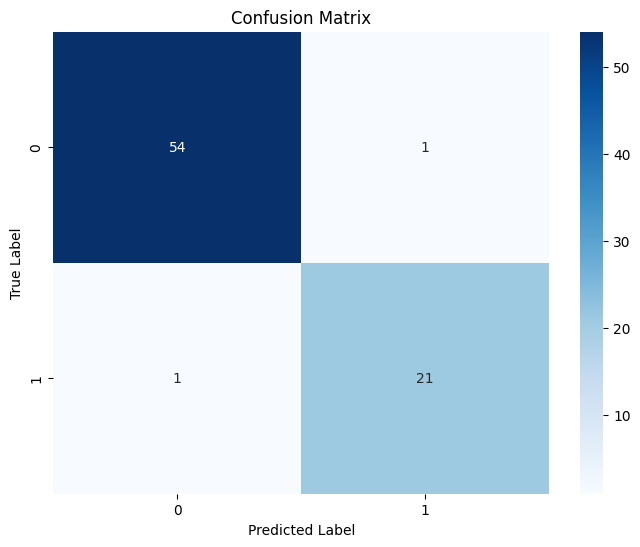

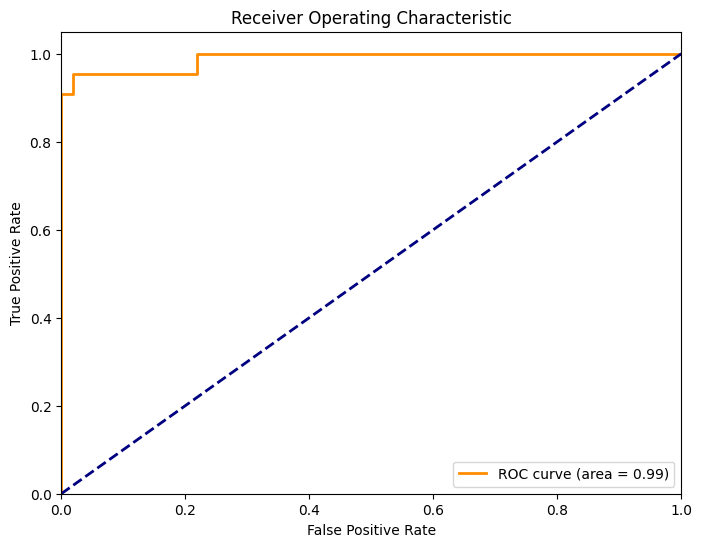

In [ ]:
print("\nModel Evaluation with Optimal Threshold:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 8. Save the Model and Preprocessor

In [ ]:
model.save('thyroid_model.h5')

with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

with open('threshold.pkl', 'wb') as f:
    pickle.dump(best_threshold, f)

print("Model, preprocessor, and threshold saved successfully.")

Model, preprocessor, and threshold saved successfully.
